In [1]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from datetime import datetime, timedelta

from sklearn.neighbors import KDTree, BallTree
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
import optuna

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

utils_directory = os.path.abspath('..')
sys.path.append(utils_directory)

import preprocessing

from utils.constant_utils import Directory
from utils import common_utils

import model
from inference import *

features_directory = os.path.abspath('../features')
sys.path.append(features_directory)

from clustering_features import *
from count_features import *
from distance_features import *
from other_features import *

/data/ephemeral/home/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print("Start the main.py successfully!")

'''
name : 실험자 이름입니다.
title : result 폴더에 저장될 실험명을 지정합니다.
'''
name = 'lim'
title = 'stacking'

print("total data load ...")
df = common_utils.merge_data(Directory.train_data, Directory.test_data)

Start the main.py successfully!
total data load ...


In [6]:
### 클러스터 피처 apply
print("clustering apply ...")
for info_df_name in ['subway_info', 'school_info', 'park_info']:
    info_df = getattr(Directory, info_df_name)  
    df = clustering(df, info_df, feat_name=info_df_name, n_clusters=20)

### 데이터 분할
print("train, valid, test split for preprocessing & feature engineering ...")
train_data_, valid_data_, test_data_ = common_utils.train_valid_test_split(df)

### 데이터 전처리
print("start to preprocessing...")
# type 카테고리화
train_data_ = preprocessing.numeric_to_categoric(train_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})
valid_data_ = preprocessing.numeric_to_categoric(valid_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})
test_data_ = preprocessing.numeric_to_categoric(test_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})

# 중복 제거
train_data_ = preprocessing.handle_duplicates(train_data_)
valid_data_ = preprocessing.handle_duplicates(valid_data_)

### 피처 엔지니어링
print("start to feature engineering...")
# clustering_feature
print("create clustering features")
train_data, valid_data, test_data = create_clustering_target(train_data_, valid_data_, test_data_)

# distance_features
print("create distance features")
train_data, valid_data, test_data = distance_gangnam(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_subway_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_park_distance_and_area(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_school_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = weighted_subway_distance(train_data, valid_data, test_data)

# other_features
print("create other features")
train_data, valid_data, test_data = create_temporal_feature(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_sin_cos_season(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_floor_area_interaction(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_sum_park_area_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = shift_interest_rate_function(train_data, valid_data, test_data)
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'floor')
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'area_m2')

# count_features
print("create count features")
#train_data, valid_data, test_data = transaction_count_function(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_subway_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_school_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_school_counts_within_radius_by_school_level(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_place_within_radius(train_data, valid_data, test_data)

### feature drop(제거하고 싶은 feature는 drop_columns로 제거됨. contract_day에 원하는 column을 추가)
train_data_ = preprocessing.drop_columns(train_data, ['contract_day'])
valid_data_ = preprocessing.drop_columns(valid_data, ['contract_day'])
test_data_ = preprocessing.drop_columns(test_data, ['contract_day'])
train_data_ = preprocessing.drop_columns(train_data, ['age'])
valid_data_ = preprocessing.drop_columns(valid_data, ['age'])
test_data_ = preprocessing.drop_columns(test_data, ['age'])


clustering apply ...
train, valid, test split for preprocessing & feature engineering ...
start to preprocessing...
start to feature engineering...
create clustering features
create distance features
create other features
create count features


In [10]:
### data save
common_utils.save_and_load_function('train_all', 'save','data', 'csv', train_data_)
common_utils.save_and_load_function('valid_all', 'save','data', 'csv', valid_data_)
common_utils.save_and_load_function('test_all', 'save','data', 'csv', test_data_)

In [2]:
### data load
train_data = common_utils.save_and_load_function('train_all', 'load','data', 'csv')
valid_data = common_utils.save_and_load_function('valid_all', 'load','data', 'csv')
test_data = common_utils.save_and_load_function('test_all', 'load','data', 'csv')

In [3]:
print("standardization...")
train_data_, valid_data_, test_data_ = preprocessing.standardization(train_data, valid_data, test_data, scaling_type = 'standard')
# feature selection
train_data, valid_data, test_data = preprocessing.feature_selection(train_data_, valid_data_, test_data_)


standardization...


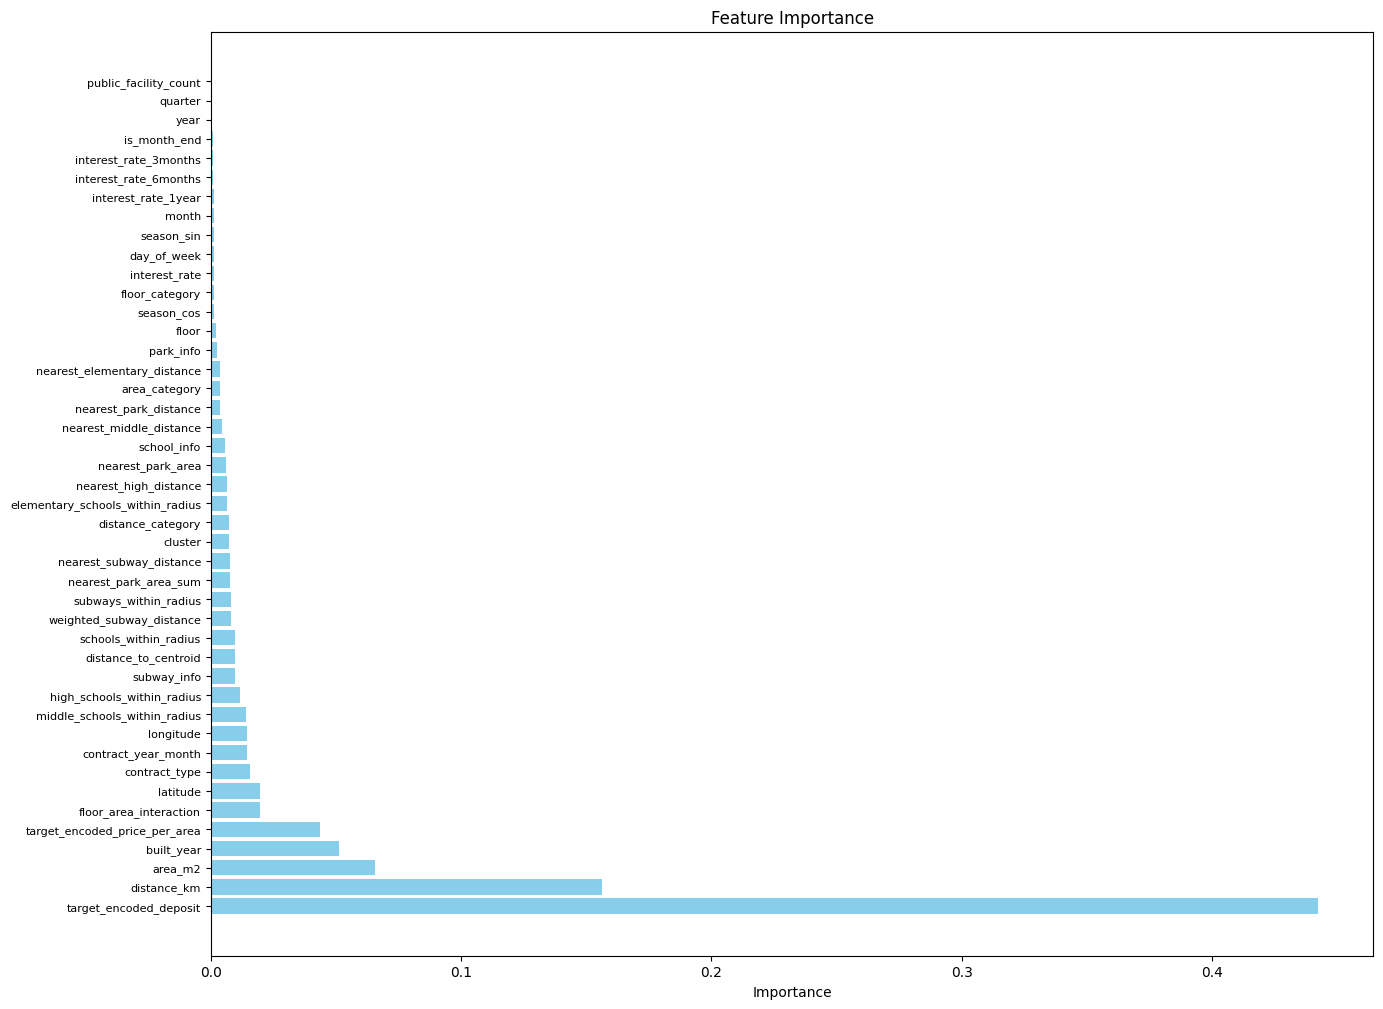

In [36]:
categorical_cols = ['contract_type','floor_category', 'area_category', 'distance_category']
for col in categorical_cols:
    train_data[col] = train_data[col].astype('category')
    valid_data[col] = valid_data[col].astype('category')
    test_data[col] = test_data[col].astype('category')

# feature split
X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data, valid_data, test_data)

model_ = model.xgboost(X_train, y_train)
# Feature importance 추출
importance = model_.feature_importances_

# Feature importance를 DataFrame으로 변환
train_df = train_data_.copy()
train_df = train_df.drop(columns = ['deposit'], axis=1)

importance_df = pd.DataFrame({
    'Feature': train_df.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Feature importance 시각화
plt.figure(figsize=(15, 12))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.yticks(fontsize=8)
plt.title('Feature Importance')
plt.show()

In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1518975 entries, 0 to 1518974
Data columns (total 45 columns):
 #   Column                            Non-Null Count    Dtype   
---  ------                            --------------    -----   
 0   area_m2                           1518975 non-null  float64 
 1   contract_year_month               1518975 non-null  float64 
 2   contract_type                     1518975 non-null  category
 3   floor                             1518975 non-null  float64 
 4   built_year                        1518975 non-null  float64 
 5   latitude                          1518975 non-null  float64 
 6   longitude                         1518975 non-null  float64 
 7   deposit                           1518975 non-null  float64 
 8   interest_rate                     1518975 non-null  float64 
 9   subway_info                       1518975 non-null  float64 
 10  school_info                       1518975 non-null  float64 
 11  park_info               

In [5]:
categorical_cols = ['contract_type','floor_category', 'area_category', 'distance_category']
for col in categorical_cols:
    train_data[col] = train_data[col].astype('category')
    valid_data[col] = valid_data[col].astype('category')
    test_data[col] = test_data[col].astype('category')

In [6]:
train_full = pd.concat([train_data, valid_data])

X = train_full.drop('deposit', axis=1)
y = train_full['deposit']

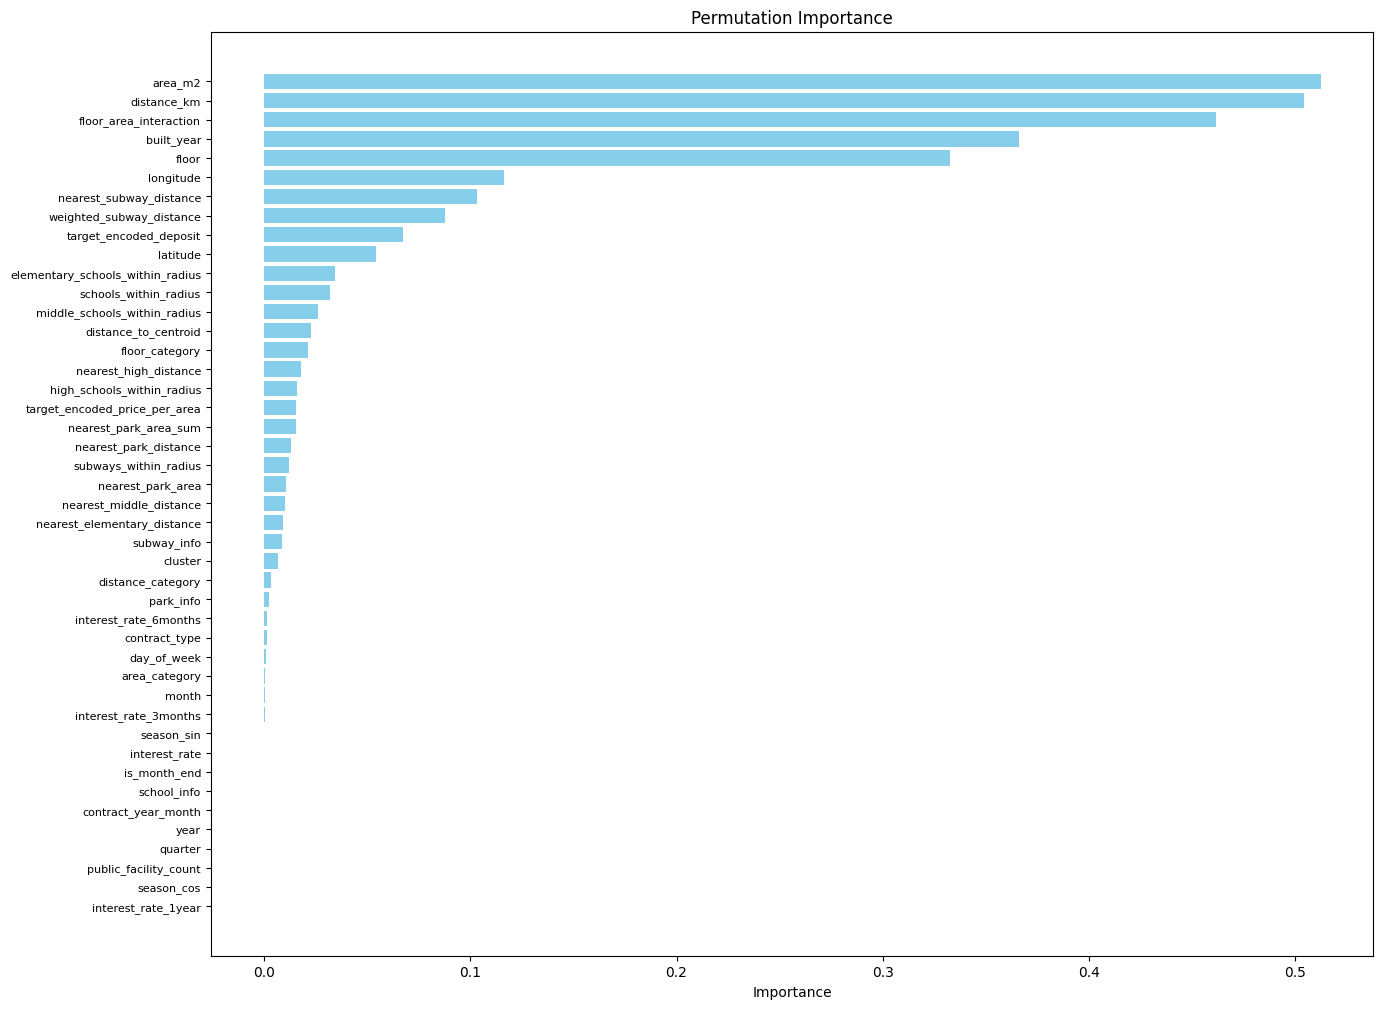

In [49]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model_, X_valid, y_valid, n_repeats=30, random_state=42)

train_df = train_data.copy()
train_df = train_df.drop(columns=['deposit'], axis=1)

importance_df = pd.DataFrame({
    'Feature': train_df.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Feature importance 시각화
plt.figure(figsize=(15, 12))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.yticks(fontsize=8)
plt.title('Permutation Importance')
plt.gca().invert_yaxis() 
plt.show()

In [50]:
threshold = np.mean(importance_df['Importance'])
selected_features = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()

print("Selected Features:", selected_features)

Selected Features: ['area_m2', 'distance_km', 'floor_area_interaction', 'built_year', 'floor', 'longitude', 'nearest_subway_distance', 'weighted_subway_distance', 'target_encoded_deposit']


In [52]:
train_data_per = train_data[selected_features+['deposit']]
valid_data_per = valid_data[selected_features+['deposit']]
test_data_per = test_data[selected_features]

X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_per, valid_data_per, test_data_per)

In [53]:
model_ = model.xgboost(X_train, y_train)
prediction, mae = inference(model_, 'validation', X_valid, y_valid)

validation Mae score
4448.155409452094


In [54]:
# record MAE score as csv
hyperparams = "basic"
common_utils.mae_to_csv(name, title, hyperparams=hyperparams, mae = mae)

# train with total dataset
print("Training with total dataset...")
X_total, y_total = common_utils.train_valid_concat(X_train, X_valid, y_train, y_valid)
model_ = model.xgboost(X_total, y_total)

# inference with test data
submission = inference(model_, 'submission', X_test)

# save sample submission
common_utils.submission_to_csv(submission, 'permutation_importance_mean')

print("Successfully executed main.py.")

Training with total dataset...
Successfully executed main.py.


In [55]:
top_20_features = list(importance_df.head(20)['Feature'].values)

In [56]:
train_data_20 = train_data[top_20_features + ['deposit']]
valid_data_20 = valid_data[top_20_features + ['deposit']]
test_data_20 = test_data[top_20_features]

X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_20, valid_data_20, test_data_20)

In [57]:
model_ = model.xgboost(X_train, y_train)
prediction, mae = inference(model_, 'validation', X_valid, y_valid)

validation Mae score
4412.416842900515


In [7]:
selected_columns = [
    'area_m2', 
    'distance_km', 
    'floor_area_interaction', 
    'built_year', 
    'floor', 
    'longitude', 
    'nearest_subway_distance', 
    'weighted_subway_distance', 
    'target_encoded_deposit',
    'latitude',
    'elementary_schools_within_radius', 
    'schools_within_radius', 
    'middle_schools_within_radius', 
    'distance_to_centroid', 
    'floor_category', 'nearest_high_distance', 
    'high_schools_within_radius', 
    'target_encoded_price_per_area', 
    'nearest_park_area_sum', 
    'nearest_park_distance'
]

In [8]:
X_selected = X[selected_columns]
test_data_selected = test_data[selected_columns]

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

# Optuna를 이용한 하이퍼파라미터 최적화
def objective(trial, model_name):
    if model_name == 'lgb_gbdt' or model_name == 'lgb_goss':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'random_state': 42,
            'enable_categorical': True
        }
        if model_name == 'lgb_goss':
            params['boosting_type'] = 'goss'
    
    elif model_name == 'catboost':
        params = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'depth': trial.suggest_int('depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'random_state': 42
        }
    
    elif model_name == 'xgboost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'random_state': 42,
            'enable_categorical': True
        }


    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    oof_predictions = np.zeros(len(X_selected))

    for train_idx, valid_idx in kf.split(X_selected):
        x_train, x_valid = X_selected.iloc[train_idx], X_selected.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        if model_name.startswith('lgb'):
            model = LGBMRegressor(**params)
        elif model_name == 'catboost':
            model = CatBoostRegressor(**params, verbose=0)
        elif model_name == 'xgboost':
            model = XGBRegressor(**params)

        model.fit(x_train, y_train)
        oof_predictions[valid_idx] = model.predict(x_valid)

    return mean_absolute_error(y, oof_predictions)

# 모델별 최적화 및 예측
models = ['lgb_gbdt', 'lgb_goss', 'catboost', 'xgboost']
val_predictions = []
test_predictions = []

for model_name in models:
    print(f"Optimizing {model_name}...")
    
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, model_name), n_trials=50, n_jobs=-1, show_progress_bar=True)

    best_params = study.best_params
    print(f"Best parameters for {model_name}: {best_params}")

    # OOF 스태킹 예측
    oof_preds = np.zeros(len(X_selected))
    test_preds_fold = np.zeros(len(test_data_selected))

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, valid_idx in kf.split(X_selected):
        x_train, x_valid = X_selected.iloc[train_idx], X_selected.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        if model_name.startswith('lgb'):
            model = LGBMRegressor(**best_params)
        elif model_name == 'catboost':
            model = CatBoostRegressor(**best_params, verbose=0)
        elif model_name == 'xgboost':
            model = XGBRegressor(**best_params)

        model.fit(x_train, y_train)
        oof_preds[valid_idx] = model.predict(x_valid)
        test_preds_fold += model.predict(test_data_selected) / kf.n_splits

    val_mae = mean_absolute_error(y, oof_preds)
    print(f"Validation MAE for {model_name}: {val_mae}")

    val_predictions.append(oof_preds)
    test_predictions.append(test_preds_fold)

    hyperparams = "stacking"
    common_utils.mae_to_csv(name, title, hyperparams=hyperparams, mae = mae)

# 스태킹 모델 학습 및 예측 
val_predictions_stacked = np.column_stack(val_predictions)
test_predictions_stacked = np.column_stack(test_predictions)

stacking_model = LinearRegression()
stacking_model.fit(val_predictions_stacked, y)

submission = inference(stacking_model, 'submission', test_predictions_stacked)

common_utils.submission_to_csv(submission, 'stacking')

print("Successfully executed main.py.")